In [8]:
# import packages
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM
import json
import os
from accelerate import Accelerator

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# Variables
model_name = 'meta-llama/Llama-3.2-1B'
non_infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/division_qa/qa.non_infringement.json'
infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/division_qa/qa.infringement.json'
checkpoint_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_last_token.pth'

In [9]:
# Define CustumMLP for internal states train
class CustomMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(CustomMLP, self).__init__()
        self.down = nn.Linear(input_dim, hidden_dim)
        self.gate = nn.Linear(input_dim, hidden_dim)
        self.up = nn.Linear(hidden_dim, 1)
        self.activation = nn.SiLU()

    def forward(self, x):
        down_output = self.down(x)
        gate_output = self.gate(x)
        gated_output = down_output * self.activation(gate_output)
        return self.up(gated_output)

In [10]:
def extract_hidden_states(texts, model, tokenizer, batch_size=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model = nn.DataParallel(model)
    hidden_states = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing data batches"):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            outputs = model(**inputs)
        
        # 访问最后一个隐藏层的最后一个token的隐藏状态
        # hidden_states[-1]表示最后一个隐藏层，mean(dim=1)表示取所有头的均值
        last_layer_hidden_states = outputs.hidden_states[-1]
        last_token_hidden_states = last_layer_hidden_states[:, -1, :]  # -1表示最后一个token
        hidden_states.append(last_token_hidden_states.cpu().numpy())
    return np.vstack(hidden_states)

In [11]:
# lode data for infringement & non infringement
def load_data(non_infringement_file, infringement_file):
    with open(non_infringement_file, 'r', encoding='utf-8') as file:
        non_infringement_json_data = json.load(file)

    non_infringement_outputs = [entry['input'] for entry in non_infringement_json_data]
    y_non_infringement = [1] * len(non_infringement_outputs)

    with open(infringement_file, 'r', encoding='utf-8') as file:
        infringement_json_data = json.load(file)

    infringement_outputs = [entry['input'] for entry in infringement_json_data]
    y_infringement = [0] * len(infringement_outputs)

    return non_infringement_outputs, y_non_infringement, infringement_outputs, y_infringement

In [12]:
from sklearn.metrics import accuracy_score, classification_report, f1_score

# Train for best model
def train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim, epochs=2000, lr=0.001, checkpoint_path=checkpoint_file):
    custom_mlp = CustomMLP(input_dim, hidden_dim)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(custom_mlp.parameters(), lr=lr)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

    best_accuracy = -float('inf')  # Initialize the best accuracy to negative infinity
    best_f1 = -float('inf')  # Initialize the best F1-score to negative infinity
    best_model_state = None  # Store the state of the best model
    best_epoch = 0  # Track the epoch with the best accuracy
    losses = []

    for epoch in tqdm(range(epochs), desc="Training Epochs"):
        custom_mlp.train()
        optimizer.zero_grad()
        outputs = custom_mlp(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")
            
            custom_mlp.eval()
            X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
            with torch.no_grad():
                y_pred_logits = custom_mlp(X_test_tensor)
                y_pred = (torch.sigmoid(y_pred_logits) > 0.5).float().numpy()
            
            accuracy = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)  # Calculate F1-score
            print(f"Test Accuracy at Epoch {epoch + 1}: {accuracy * 100:.2f}%")
            print(f"Test F1-score at Epoch {epoch + 1}: {f1:.4f}")
            
            report = classification_report(y_test, y_pred, target_names=["infringement", "non_infringement"])
            print(f"Classification Report at Epoch {epoch + 1}:\n{report}")

            # Check if the current model is the best based on F1-score
            if f1 > best_f1:
                best_accuracy = accuracy
                best_f1 = f1
                best_model_state = custom_mlp.state_dict()
                best_epoch = epoch + 1
                torch.save(best_model_state, checkpoint_path)
                print(f"New best model saved with F1-score {best_f1:.4f} at epoch {best_epoch}")
                print(f"Best Classification Report at Epoch {best_epoch}:\n{report}")

    # Load the best model state
    custom_mlp.load_state_dict(torch.load(checkpoint_path))

    # Plot loss curve
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.show()

    print(f"Best Model was saved at epoch {best_epoch} with F1-score {best_f1:.4f} and accuracy {best_accuracy * 100:.2f}%")
    return custom_mlp, losses, best_accuracy, best_f1


In [13]:

tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)
model = AutoModelForCausalLM.from_pretrained(model_name, output_hidden_states=True)
tokenizer.pad_token = tokenizer.eos_token

non_infringement_outputs, y_non_infringement, infringement_outputs, y_infringement = load_data(non_infringement_file, infringement_file)

y_non_infringement = np.array(y_non_infringement)
y_infringement = np.array(y_infringement)


accelerator = Accelerator()
model, non_infringement_outputs, infringement_outputs = accelerator.prepare(model, non_infringement_outputs, infringement_outputs)

/home/guangwei/miniconda3/envs/zdh/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:774: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [14]:
print("Extracting hidden states for non_infringement texts...")
X_non_infringement = extract_hidden_states(non_infringement_outputs, model, tokenizer)

print("Extracting hidden states for infringement texts...")
X_infringement = extract_hidden_states(infringement_outputs, model, tokenizer)

Extracting hidden states for non_infringement texts...


Processing data batches: 100%|██████████| 79/79 [00:02<00:00, 30.74it/s]


Extracting hidden states for infringement texts...


Processing data batches: 100%|██████████| 39/39 [00:01<00:00, 34.94it/s]


In [15]:
split_index_non_infringement = int(0.8 * len(X_non_infringement))
X_non_infringement_train = X_non_infringement[:split_index_non_infringement]
X_non_infringement_test = X_non_infringement[split_index_non_infringement:]
y_non_infringement_train = y_non_infringement[:split_index_non_infringement]
y_non_infringement_test = y_non_infringement[split_index_non_infringement:]

split_index_infringement = int(0.8 * len(X_infringement))
X_infringement_train = X_infringement[:split_index_infringement]
X_infringement_test = X_infringement[split_index_infringement:]
y_infringement_train = y_infringement[:split_index_infringement]
y_infringement_test = y_infringement[split_index_infringement:]

X_train = np.vstack((X_non_infringement_train, X_infringement_train))
X_test = np.vstack((X_non_infringement_test, X_infringement_test))
y_train = np.concatenate((y_non_infringement_train, y_infringement_train))
y_test = np.concatenate((y_non_infringement_test, y_infringement_test))

print("Data successfully split into training and test sets.")


Data successfully split into training and test sets.


Training Epochs:   0%|          | 8/2000 [00:00<00:53, 37.13it/s]/home/guangwei/miniconda3/envs/zdh/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/guangwei/miniconda3/envs/zdh/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/guangwei/miniconda3/envs/zdh/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control 

Epoch 10/2000, Loss: 0.5975
Test Accuracy at Epoch 10: 67.37%
Test F1-score at Epoch 10: 0.8050
Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.00      0.00      0.00        31
non_infringement       0.67      1.00      0.81        64

        accuracy                           0.67        95
       macro avg       0.34      0.50      0.40        95
    weighted avg       0.45      0.67      0.54        95

New best model saved with F1-score 0.8050 at epoch 10
Best Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.00      0.00      0.00        31
non_infringement       0.67      1.00      0.81        64

        accuracy                           0.67        95
       macro avg       0.34      0.50      0.40        95
    weighted avg       0.45      0.67      0.54        95



Training Epochs:   1%|          | 17/2000 [00:00<01:29, 22.24it/s]/home/guangwei/miniconda3/envs/zdh/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/guangwei/miniconda3/envs/zdh/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/guangwei/miniconda3/envs/zdh/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control

Epoch 20/2000, Loss: 0.5604
Test Accuracy at Epoch 20: 67.37%
Test F1-score at Epoch 20: 0.8050
Classification Report at Epoch 20:
                  precision    recall  f1-score   support

    infringement       0.00      0.00      0.00        31
non_infringement       0.67      1.00      0.81        64

        accuracy                           0.67        95
       macro avg       0.34      0.50      0.40        95
    weighted avg       0.45      0.67      0.54        95



Training Epochs:   1%|▏         | 26/2000 [00:03<05:56,  5.54it/s]/home/guangwei/miniconda3/envs/zdh/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/guangwei/miniconda3/envs/zdh/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/guangwei/miniconda3/envs/zdh/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control

Epoch 30/2000, Loss: 0.4980
Test Accuracy at Epoch 30: 67.37%
Test F1-score at Epoch 30: 0.8050
Classification Report at Epoch 30:
                  precision    recall  f1-score   support

    infringement       0.00      0.00      0.00        31
non_infringement       0.67      1.00      0.81        64

        accuracy                           0.67        95
       macro avg       0.34      0.50      0.40        95
    weighted avg       0.45      0.67      0.54        95



Training Epochs:   2%|▏         | 46/2000 [00:05<03:11, 10.22it/s]

Epoch 40/2000, Loss: 0.4127
Test Accuracy at Epoch 40: 65.26%
Test F1-score at Epoch 40: 0.7898
Classification Report at Epoch 40:
                  precision    recall  f1-score   support

    infringement       0.00      0.00      0.00        31
non_infringement       0.67      0.97      0.79        64

        accuracy                           0.65        95
       macro avg       0.33      0.48      0.39        95
    weighted avg       0.45      0.65      0.53        95



Training Epochs:   2%|▏         | 49/2000 [00:05<02:36, 12.43it/s]

Epoch 50/2000, Loss: 0.4328
Test Accuracy at Epoch 50: 63.16%
Test F1-score at Epoch 50: 0.7682
Classification Report at Epoch 50:
                  precision    recall  f1-score   support

    infringement       0.25      0.06      0.10        31
non_infringement       0.67      0.91      0.77        64

        accuracy                           0.63        95
       macro avg       0.46      0.49      0.44        95
    weighted avg       0.53      0.63      0.55        95



Training Epochs:   3%|▎         | 60/2000 [00:06<02:29, 12.97it/s]

Epoch 60/2000, Loss: 0.3785
Test Accuracy at Epoch 60: 63.16%
Test F1-score at Epoch 60: 0.7682
Classification Report at Epoch 60:
                  precision    recall  f1-score   support

    infringement       0.25      0.06      0.10        31
non_infringement       0.67      0.91      0.77        64

        accuracy                           0.63        95
       macro avg       0.46      0.49      0.44        95
    weighted avg       0.53      0.63      0.55        95



Training Epochs:   4%|▎         | 73/2000 [00:07<01:39, 19.44it/s]

Epoch 70/2000, Loss: 0.3425
Test Accuracy at Epoch 70: 62.11%
Test F1-score at Epoch 70: 0.7632
Classification Report at Epoch 70:
                  precision    recall  f1-score   support

    infringement       0.14      0.03      0.05        31
non_infringement       0.66      0.91      0.76        64

        accuracy                           0.62        95
       macro avg       0.40      0.47      0.41        95
    weighted avg       0.49      0.62      0.53        95



Training Epochs:   4%|▍         | 81/2000 [00:07<01:14, 25.74it/s]

Epoch 80/2000, Loss: 0.3191
Test Accuracy at Epoch 80: 64.21%
Test F1-score at Epoch 80: 0.7703
Classification Report at Epoch 80:
                  precision    recall  f1-score   support

    infringement       0.36      0.13      0.19        31
non_infringement       0.68      0.89      0.77        64

        accuracy                           0.64        95
       macro avg       0.52      0.51      0.48        95
    weighted avg       0.58      0.64      0.58        95



Training Epochs:   4%|▍         | 90/2000 [00:11<08:23,  3.79it/s]

Epoch 90/2000, Loss: 0.4331
Test Accuracy at Epoch 90: 50.53%
Test F1-score at Epoch 90: 0.5913
Classification Report at Epoch 90:
                  precision    recall  f1-score   support

    infringement       0.32      0.45      0.37        31
non_infringement       0.67      0.53      0.59        64

        accuracy                           0.51        95
       macro avg       0.49      0.49      0.48        95
    weighted avg       0.55      0.51      0.52        95



Training Epochs:   5%|▌         | 107/2000 [00:11<02:25, 13.02it/s]

Epoch 100/2000, Loss: 0.3269
Test Accuracy at Epoch 100: 57.89%
Test F1-score at Epoch 100: 0.6970
Classification Report at Epoch 100:
                  precision    recall  f1-score   support

    infringement       0.33      0.29      0.31        31
non_infringement       0.68      0.72      0.70        64

        accuracy                           0.58        95
       macro avg       0.50      0.50      0.50        95
    weighted avg       0.56      0.58      0.57        95



Training Epochs:   6%|▌         | 117/2000 [00:12<01:28, 21.16it/s]

Epoch 110/2000, Loss: 0.2925
Test Accuracy at Epoch 110: 51.58%
Test F1-score at Epoch 110: 0.6290
Classification Report at Epoch 110:
                  precision    recall  f1-score   support

    infringement       0.29      0.32      0.30        31
non_infringement       0.65      0.61      0.63        64

        accuracy                           0.52        95
       macro avg       0.47      0.47      0.47        95
    weighted avg       0.53      0.52      0.52        95



Training Epochs:   6%|▌         | 121/2000 [00:12<01:20, 23.25it/s]

Epoch 120/2000, Loss: 0.2648
Test Accuracy at Epoch 120: 60.00%
Test F1-score at Epoch 120: 0.7324
Classification Report at Epoch 120:
                  precision    recall  f1-score   support

    infringement       0.29      0.16      0.21        31
non_infringement       0.67      0.81      0.73        64

        accuracy                           0.60        95
       macro avg       0.48      0.49      0.47        95
    weighted avg       0.55      0.60      0.56        95



Training Epochs:   7%|▋         | 132/2000 [00:14<02:56, 10.60it/s]

Epoch 130/2000, Loss: 0.2542
Test Accuracy at Epoch 130: 63.16%
Test F1-score at Epoch 130: 0.7682
Classification Report at Epoch 130:
                  precision    recall  f1-score   support

    infringement       0.25      0.06      0.10        31
non_infringement       0.67      0.91      0.77        64

        accuracy                           0.63        95
       macro avg       0.46      0.49      0.44        95
    weighted avg       0.53      0.63      0.55        95



Training Epochs:   7%|▋         | 144/2000 [00:14<01:57, 15.75it/s]

Epoch 140/2000, Loss: 0.2268
Test Accuracy at Epoch 140: 60.00%
Test F1-score at Epoch 140: 0.7324
Classification Report at Epoch 140:
                  precision    recall  f1-score   support

    infringement       0.29      0.16      0.21        31
non_infringement       0.67      0.81      0.73        64

        accuracy                           0.60        95
       macro avg       0.48      0.49      0.47        95
    weighted avg       0.55      0.60      0.56        95



Training Epochs:   8%|▊         | 157/2000 [00:14<01:08, 26.96it/s]

Epoch 150/2000, Loss: 0.2680
Test Accuracy at Epoch 150: 50.53%
Test F1-score at Epoch 150: 0.6299
Classification Report at Epoch 150:
                  precision    recall  f1-score   support

    infringement       0.25      0.26      0.25        31
non_infringement       0.63      0.62      0.63        64

        accuracy                           0.51        95
       macro avg       0.44      0.44      0.44        95
    weighted avg       0.51      0.51      0.51        95



Training Epochs:   8%|▊         | 165/2000 [00:15<01:18, 23.39it/s]

Epoch 160/2000, Loss: 0.3088
Test Accuracy at Epoch 160: 52.63%
Test F1-score at Epoch 160: 0.6617
Classification Report at Epoch 160:
                  precision    recall  f1-score   support

    infringement       0.23      0.19      0.21        31
non_infringement       0.64      0.69      0.66        64

        accuracy                           0.53        95
       macro avg       0.43      0.44      0.44        95
    weighted avg       0.50      0.53      0.51        95



Training Epochs:   8%|▊         | 170/2000 [00:15<01:07, 27.17it/s]

Epoch 170/2000, Loss: 0.1904
Test Accuracy at Epoch 170: 57.89%
Test F1-score at Epoch 170: 0.7143
Classification Report at Epoch 170:
                  precision    recall  f1-score   support

    infringement       0.26      0.16      0.20        31
non_infringement       0.66      0.78      0.71        64

        accuracy                           0.58        95
       macro avg       0.46      0.47      0.46        95
    weighted avg       0.53      0.58      0.55        95



Training Epochs:   9%|▉         | 177/2000 [00:16<02:46, 10.93it/s]

Epoch 180/2000, Loss: 0.1566
Test Accuracy at Epoch 180: 55.79%
Test F1-score at Epoch 180: 0.6957
Classification Report at Epoch 180:
                  precision    recall  f1-score   support

    infringement       0.24      0.16      0.19        31
non_infringement       0.65      0.75      0.70        64

        accuracy                           0.56        95
       macro avg       0.44      0.46      0.44        95
    weighted avg       0.51      0.56      0.53        95



Training Epochs:  10%|▉         | 196/2000 [00:18<02:01, 14.81it/s]

Epoch 190/2000, Loss: 0.2620
Test Accuracy at Epoch 190: 61.05%
Test F1-score at Epoch 190: 0.7517
Classification Report at Epoch 190:
                  precision    recall  f1-score   support

    infringement       0.20      0.06      0.10        31
non_infringement       0.66      0.88      0.75        64

        accuracy                           0.61        95
       macro avg       0.43      0.47      0.42        95
    weighted avg       0.51      0.61      0.54        95



Training Epochs:  10%|█         | 203/2000 [00:18<01:31, 19.59it/s]

Epoch 200/2000, Loss: 0.1766
Test Accuracy at Epoch 200: 62.11%
Test F1-score at Epoch 200: 0.7600
Classification Report at Epoch 200:
                  precision    recall  f1-score   support

    infringement       0.22      0.06      0.10        31
non_infringement       0.66      0.89      0.76        64

        accuracy                           0.62        95
       macro avg       0.44      0.48      0.43        95
    weighted avg       0.52      0.62      0.54        95



Training Epochs:  11%|█         | 215/2000 [00:19<01:01, 29.24it/s]

Epoch 210/2000, Loss: 0.2390
Test Accuracy at Epoch 210: 62.11%
Test F1-score at Epoch 210: 0.7500
Classification Report at Epoch 210:
                  precision    recall  f1-score   support

    infringement       0.33      0.16      0.22        31
non_infringement       0.68      0.84      0.75        64

        accuracy                           0.62        95
       macro avg       0.50      0.50      0.48        95
    weighted avg       0.56      0.62      0.58        95



Training Epochs:  11%|█         | 220/2000 [00:19<00:54, 32.54it/s]

Epoch 220/2000, Loss: 0.2183
Test Accuracy at Epoch 220: 61.05%
Test F1-score at Epoch 220: 0.7448
Classification Report at Epoch 220:
                  precision    recall  f1-score   support

    infringement       0.29      0.13      0.18        31
non_infringement       0.67      0.84      0.74        64

        accuracy                           0.61        95
       macro avg       0.48      0.49      0.46        95
    weighted avg       0.54      0.61      0.56        95



Training Epochs:  11%|█▏        | 229/2000 [00:21<05:34,  5.30it/s]

Epoch 230/2000, Loss: 0.1921
Test Accuracy at Epoch 230: 60.00%
Test F1-score at Epoch 230: 0.7324
Classification Report at Epoch 230:
                  precision    recall  f1-score   support

    infringement       0.29      0.16      0.21        31
non_infringement       0.67      0.81      0.73        64

        accuracy                           0.60        95
       macro avg       0.48      0.49      0.47        95
    weighted avg       0.55      0.60      0.56        95



Training Epochs:  12%|█▏        | 245/2000 [00:24<02:59,  9.80it/s]

Epoch 240/2000, Loss: 0.1731
Test Accuracy at Epoch 240: 60.00%
Test F1-score at Epoch 240: 0.7324
Classification Report at Epoch 240:
                  precision    recall  f1-score   support

    infringement       0.29      0.16      0.21        31
non_infringement       0.67      0.81      0.73        64

        accuracy                           0.60        95
       macro avg       0.48      0.49      0.47        95
    weighted avg       0.55      0.60      0.56        95



Training Epochs:  13%|█▎        | 251/2000 [00:25<03:53,  7.49it/s]

Epoch 250/2000, Loss: 0.1569
Test Accuracy at Epoch 250: 58.95%
Test F1-score at Epoch 250: 0.7234
Classification Report at Epoch 250:
                  precision    recall  f1-score   support

    infringement       0.28      0.16      0.20        31
non_infringement       0.66      0.80      0.72        64

        accuracy                           0.59        95
       macro avg       0.47      0.48      0.46        95
    weighted avg       0.54      0.59      0.55        95



Training Epochs:  13%|█▎        | 262/2000 [00:25<01:45, 16.55it/s]

Epoch 260/2000, Loss: 0.3761
Test Accuracy at Epoch 260: 60.00%
Test F1-score at Epoch 260: 0.7246
Classification Report at Epoch 260:
                  precision    recall  f1-score   support

    infringement       0.33      0.23      0.27        31
non_infringement       0.68      0.78      0.72        64

        accuracy                           0.60        95
       macro avg       0.50      0.50      0.50        95
    weighted avg       0.56      0.60      0.58        95



Training Epochs:  14%|█▍        | 276/2000 [00:26<01:12, 23.83it/s]

Epoch 270/2000, Loss: 0.1685
Test Accuracy at Epoch 270: 62.11%
Test F1-score at Epoch 270: 0.7600
Classification Report at Epoch 270:
                  precision    recall  f1-score   support

    infringement       0.22      0.06      0.10        31
non_infringement       0.66      0.89      0.76        64

        accuracy                           0.62        95
       macro avg       0.44      0.48      0.43        95
    weighted avg       0.52      0.62      0.54        95



Training Epochs:  14%|█▍        | 280/2000 [00:26<01:06, 26.00it/s]

Epoch 280/2000, Loss: 0.1309
Test Accuracy at Epoch 280: 57.89%
Test F1-score at Epoch 280: 0.7183
Classification Report at Epoch 280:
                  precision    recall  f1-score   support

    infringement       0.24      0.13      0.17        31
non_infringement       0.65      0.80      0.72        64

        accuracy                           0.58        95
       macro avg       0.44      0.46      0.44        95
    weighted avg       0.52      0.58      0.54        95



Training Epochs:  14%|█▍        | 289/2000 [00:29<06:16,  4.54it/s]

Epoch 290/2000, Loss: 0.1501
Test Accuracy at Epoch 290: 62.11%
Test F1-score at Epoch 290: 0.7600
Classification Report at Epoch 290:
                  precision    recall  f1-score   support

    infringement       0.22      0.06      0.10        31
non_infringement       0.66      0.89      0.76        64

        accuracy                           0.62        95
       macro avg       0.44      0.48      0.43        95
    weighted avg       0.52      0.62      0.54        95



Training Epochs:  15%|█▌        | 300/2000 [00:30<03:18,  8.55it/s]

Epoch 300/2000, Loss: 0.1326
Test Accuracy at Epoch 300: 57.89%
Test F1-score at Epoch 300: 0.7143
Classification Report at Epoch 300:
                  precision    recall  f1-score   support

    infringement       0.26      0.16      0.20        31
non_infringement       0.66      0.78      0.71        64

        accuracy                           0.58        95
       macro avg       0.46      0.47      0.46        95
    weighted avg       0.53      0.58      0.55        95



Training Epochs:  16%|█▌        | 316/2000 [00:31<01:33, 18.03it/s]

Epoch 310/2000, Loss: 0.1620
Test Accuracy at Epoch 310: 58.95%
Test F1-score at Epoch 310: 0.7347
Classification Report at Epoch 310:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  16%|█▌        | 324/2000 [00:31<01:08, 24.33it/s]

Epoch 320/2000, Loss: 0.1152
Test Accuracy at Epoch 320: 60.00%
Test F1-score at Epoch 320: 0.7397
Classification Report at Epoch 320:
                  precision    recall  f1-score   support

    infringement       0.23      0.10      0.14        31
non_infringement       0.66      0.84      0.74        64

        accuracy                           0.60        95
       macro avg       0.44      0.47      0.44        95
    weighted avg       0.52      0.60      0.54        95



Training Epochs:  17%|█▋        | 333/2000 [00:31<00:55, 30.10it/s]

Epoch 330/2000, Loss: 0.1066
Test Accuracy at Epoch 330: 61.05%
Test F1-score at Epoch 330: 0.7517
Classification Report at Epoch 330:
                  precision    recall  f1-score   support

    infringement       0.20      0.06      0.10        31
non_infringement       0.66      0.88      0.75        64

        accuracy                           0.61        95
       macro avg       0.43      0.47      0.42        95
    weighted avg       0.51      0.61      0.54        95



Training Epochs:  17%|█▋        | 346/2000 [00:32<00:46, 35.43it/s]

Epoch 340/2000, Loss: 0.3154
Test Accuracy at Epoch 340: 55.79%
Test F1-score at Epoch 340: 0.6957
Classification Report at Epoch 340:
                  precision    recall  f1-score   support

    infringement       0.24      0.16      0.19        31
non_infringement       0.65      0.75      0.70        64

        accuracy                           0.56        95
       macro avg       0.44      0.46      0.44        95
    weighted avg       0.51      0.56      0.53        95



Training Epochs:  18%|█▊        | 350/2000 [00:34<04:06,  6.69it/s]

Epoch 350/2000, Loss: 0.1064
Test Accuracy at Epoch 350: 61.05%
Test F1-score at Epoch 350: 0.7550
Classification Report at Epoch 350:
                  precision    recall  f1-score   support

    infringement       0.12      0.03      0.05        31
non_infringement       0.66      0.89      0.75        64

        accuracy                           0.61        95
       macro avg       0.39      0.46      0.40        95
    weighted avg       0.48      0.61      0.53        95



Training Epochs:  18%|█▊        | 367/2000 [00:37<03:12,  8.48it/s]

Epoch 360/2000, Loss: 0.0836
Test Accuracy at Epoch 360: 57.89%
Test F1-score at Epoch 360: 0.7260
Classification Report at Epoch 360:
                  precision    recall  f1-score   support

    infringement       0.15      0.06      0.09        31
non_infringement       0.65      0.83      0.73        64

        accuracy                           0.58        95
       macro avg       0.40      0.45      0.41        95
    weighted avg       0.49      0.58      0.52        95



Training Epochs:  18%|█▊        | 370/2000 [00:38<05:37,  4.83it/s]

Epoch 370/2000, Loss: 0.0826
Test Accuracy at Epoch 370: 61.05%
Test F1-score at Epoch 370: 0.7517
Classification Report at Epoch 370:
                  precision    recall  f1-score   support

    infringement       0.20      0.06      0.10        31
non_infringement       0.66      0.88      0.75        64

        accuracy                           0.61        95
       macro avg       0.43      0.47      0.42        95
    weighted avg       0.51      0.61      0.54        95



Training Epochs:  19%|█▉        | 385/2000 [00:41<02:51,  9.41it/s]

Epoch 380/2000, Loss: 0.2400
Test Accuracy at Epoch 380: 61.05%
Test F1-score at Epoch 380: 0.7550
Classification Report at Epoch 380:
                  precision    recall  f1-score   support

    infringement       0.12      0.03      0.05        31
non_infringement       0.66      0.89      0.75        64

        accuracy                           0.61        95
       macro avg       0.39      0.46      0.40        95
    weighted avg       0.48      0.61      0.53        95



Training Epochs:  20%|█▉        | 395/2000 [00:41<01:27, 18.34it/s]

Epoch 390/2000, Loss: 0.0940
Test Accuracy at Epoch 390: 56.84%
Test F1-score at Epoch 390: 0.7172
Classification Report at Epoch 390:
                  precision    recall  f1-score   support

    infringement       0.14      0.06      0.09        31
non_infringement       0.64      0.81      0.72        64

        accuracy                           0.57        95
       macro avg       0.39      0.44      0.40        95
    weighted avg       0.48      0.57      0.51        95



Training Epochs:  20%|██        | 405/2000 [00:41<00:58, 27.45it/s]

Epoch 400/2000, Loss: 0.0617
Test Accuracy at Epoch 400: 61.05%
Test F1-score at Epoch 400: 0.7517
Classification Report at Epoch 400:
                  precision    recall  f1-score   support

    infringement       0.20      0.06      0.10        31
non_infringement       0.66      0.88      0.75        64

        accuracy                           0.61        95
       macro avg       0.43      0.47      0.42        95
    weighted avg       0.51      0.61      0.54        95



Training Epochs:  21%|██        | 415/2000 [00:42<00:44, 35.75it/s]

Epoch 410/2000, Loss: 0.0507
Test Accuracy at Epoch 410: 57.89%
Test F1-score at Epoch 410: 0.7260
Classification Report at Epoch 410:
                  precision    recall  f1-score   support

    infringement       0.15      0.06      0.09        31
non_infringement       0.65      0.83      0.73        64

        accuracy                           0.58        95
       macro avg       0.40      0.45      0.41        95
    weighted avg       0.49      0.58      0.52        95



Training Epochs:  21%|██        | 420/2000 [00:42<00:43, 36.60it/s]

Epoch 420/2000, Loss: 0.0438
Test Accuracy at Epoch 420: 58.95%
Test F1-score at Epoch 420: 0.7347
Classification Report at Epoch 420:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  21%|██▏       | 429/2000 [00:45<04:54,  5.34it/s]

Epoch 430/2000, Loss: 0.0355
Test Accuracy at Epoch 430: 58.95%
Test F1-score at Epoch 430: 0.7347
Classification Report at Epoch 430:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  22%|██▏       | 445/2000 [00:47<02:32, 10.21it/s]

Epoch 440/2000, Loss: 0.0291
Test Accuracy at Epoch 440: 60.00%
Test F1-score at Epoch 440: 0.7432
Classification Report at Epoch 440:
                  precision    recall  f1-score   support

    infringement       0.18      0.06      0.10        31
non_infringement       0.65      0.86      0.74        64

        accuracy                           0.60        95
       macro avg       0.42      0.46      0.42        95
    weighted avg       0.50      0.60      0.53        95



Training Epochs:  23%|██▎       | 454/2000 [00:49<03:24,  7.55it/s]

Epoch 450/2000, Loss: 0.0240
Test Accuracy at Epoch 450: 60.00%
Test F1-score at Epoch 450: 0.7432
Classification Report at Epoch 450:
                  precision    recall  f1-score   support

    infringement       0.18      0.06      0.10        31
non_infringement       0.65      0.86      0.74        64

        accuracy                           0.60        95
       macro avg       0.42      0.46      0.42        95
    weighted avg       0.50      0.60      0.53        95



Training Epochs:  23%|██▎       | 463/2000 [00:49<01:47, 14.34it/s]

Epoch 460/2000, Loss: 0.0199
Test Accuracy at Epoch 460: 60.00%
Test F1-score at Epoch 460: 0.7432
Classification Report at Epoch 460:
                  precision    recall  f1-score   support

    infringement       0.18      0.06      0.10        31
non_infringement       0.65      0.86      0.74        64

        accuracy                           0.60        95
       macro avg       0.42      0.46      0.42        95
    weighted avg       0.50      0.60      0.53        95



Training Epochs:  24%|██▍       | 477/2000 [00:49<00:57, 26.63it/s]

Epoch 470/2000, Loss: 0.0166
Test Accuracy at Epoch 470: 60.00%
Test F1-score at Epoch 470: 0.7432
Classification Report at Epoch 470:
                  precision    recall  f1-score   support

    infringement       0.18      0.06      0.10        31
non_infringement       0.65      0.86      0.74        64

        accuracy                           0.60        95
       macro avg       0.42      0.46      0.42        95
    weighted avg       0.50      0.60      0.53        95



Training Epochs:  24%|██▍       | 488/2000 [00:50<00:42, 35.44it/s]

Epoch 480/2000, Loss: 0.0141
Test Accuracy at Epoch 480: 60.00%
Test F1-score at Epoch 480: 0.7432
Classification Report at Epoch 480:
                  precision    recall  f1-score   support

    infringement       0.18      0.06      0.10        31
non_infringement       0.65      0.86      0.74        64

        accuracy                           0.60        95
       macro avg       0.42      0.46      0.42        95
    weighted avg       0.50      0.60      0.53        95



Training Epochs:  25%|██▍       | 493/2000 [00:50<00:40, 37.58it/s]

Epoch 490/2000, Loss: 0.0120
Test Accuracy at Epoch 490: 60.00%
Test F1-score at Epoch 490: 0.7432
Classification Report at Epoch 490:
                  precision    recall  f1-score   support

    infringement       0.18      0.06      0.10        31
non_infringement       0.65      0.86      0.74        64

        accuracy                           0.60        95
       macro avg       0.42      0.46      0.42        95
    weighted avg       0.50      0.60      0.53        95



Training Epochs:  25%|██▍       | 498/2000 [00:50<01:09, 21.67it/s]

Epoch 500/2000, Loss: 0.0103
Test Accuracy at Epoch 500: 58.95%
Test F1-score at Epoch 500: 0.7347
Classification Report at Epoch 500:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  25%|██▌       | 509/2000 [00:55<06:30,  3.82it/s]

Epoch 510/2000, Loss: 0.0090
Test Accuracy at Epoch 510: 58.95%
Test F1-score at Epoch 510: 0.7347
Classification Report at Epoch 510:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  26%|██▋       | 526/2000 [00:56<02:04, 11.84it/s]

Epoch 520/2000, Loss: 0.0079
Test Accuracy at Epoch 520: 58.95%
Test F1-score at Epoch 520: 0.7347
Classification Report at Epoch 520:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  27%|██▋       | 531/2000 [00:57<03:25,  7.15it/s]

Epoch 530/2000, Loss: 0.0069
Test Accuracy at Epoch 530: 58.95%
Test F1-score at Epoch 530: 0.7347
Classification Report at Epoch 530:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  27%|██▋       | 544/2000 [00:57<01:23, 17.43it/s]

Epoch 540/2000, Loss: 0.0062
Test Accuracy at Epoch 540: 58.95%
Test F1-score at Epoch 540: 0.7347
Classification Report at Epoch 540:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  28%|██▊       | 553/2000 [00:58<01:00, 23.93it/s]

Epoch 550/2000, Loss: 0.0055
Test Accuracy at Epoch 550: 58.95%
Test F1-score at Epoch 550: 0.7347
Classification Report at Epoch 550:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  28%|██▊       | 563/2000 [00:58<00:42, 33.48it/s]

Epoch 560/2000, Loss: 0.0050
Test Accuracy at Epoch 560: 58.95%
Test F1-score at Epoch 560: 0.7347
Classification Report at Epoch 560:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  29%|██▊       | 573/2000 [00:58<00:41, 34.64it/s]

Epoch 570/2000, Loss: 0.0045
Test Accuracy at Epoch 570: 58.95%
Test F1-score at Epoch 570: 0.7347
Classification Report at Epoch 570:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  29%|██▉       | 580/2000 [01:01<04:25,  5.34it/s]

Epoch 580/2000, Loss: 0.0041
Test Accuracy at Epoch 580: 58.95%
Test F1-score at Epoch 580: 0.7347
Classification Report at Epoch 580:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  30%|██▉       | 590/2000 [01:06<09:24,  2.50it/s]

Epoch 590/2000, Loss: 0.0037
Test Accuracy at Epoch 590: 58.95%
Test F1-score at Epoch 590: 0.7347
Classification Report at Epoch 590:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  30%|███       | 600/2000 [01:10<09:55,  2.35it/s]

Epoch 600/2000, Loss: 0.0034
Test Accuracy at Epoch 600: 58.95%
Test F1-score at Epoch 600: 0.7347
Classification Report at Epoch 600:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  30%|███       | 610/2000 [01:14<09:03,  2.56it/s]

Epoch 610/2000, Loss: 0.0032
Test Accuracy at Epoch 610: 58.95%
Test F1-score at Epoch 610: 0.7347
Classification Report at Epoch 610:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  31%|███       | 620/2000 [01:18<10:05,  2.28it/s]

Epoch 620/2000, Loss: 0.0029
Test Accuracy at Epoch 620: 58.95%
Test F1-score at Epoch 620: 0.7347
Classification Report at Epoch 620:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  32%|███▏      | 636/2000 [01:22<02:20,  9.74it/s]

Epoch 630/2000, Loss: 0.0027
Test Accuracy at Epoch 630: 58.95%
Test F1-score at Epoch 630: 0.7347
Classification Report at Epoch 630:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  32%|███▏      | 646/2000 [01:22<01:03, 21.34it/s]

Epoch 640/2000, Loss: 0.0025
Test Accuracy at Epoch 640: 58.95%
Test F1-score at Epoch 640: 0.7347
Classification Report at Epoch 640:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95

Epoch 650/2000, Loss: 0.0024


Training Epochs:  33%|███▎      | 658/2000 [01:22<00:41, 32.32it/s]

Test Accuracy at Epoch 650: 58.95%
Test F1-score at Epoch 650: 0.7347
Classification Report at Epoch 650:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  33%|███▎      | 669/2000 [01:23<00:32, 40.98it/s]

Epoch 660/2000, Loss: 0.0022
Test Accuracy at Epoch 660: 58.95%
Test F1-score at Epoch 660: 0.7347
Classification Report at Epoch 660:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95

Epoch 670/2000, Loss: 0.0021
Test Accuracy at Epoch 670: 58.95%
Test F1-score at Epoch 670: 0.7347
Classification Report at Epoch 670:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  34%|███▍      | 678/2000 [01:25<02:42,  8.11it/s]

Epoch 680/2000, Loss: 0.0020
Test Accuracy at Epoch 680: 58.95%
Test F1-score at Epoch 680: 0.7347
Classification Report at Epoch 680:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  34%|███▍      | 690/2000 [01:29<07:10,  3.04it/s]

Epoch 690/2000, Loss: 0.0018
Test Accuracy at Epoch 690: 58.95%
Test F1-score at Epoch 690: 0.7347
Classification Report at Epoch 690:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  35%|███▌      | 700/2000 [01:33<08:32,  2.54it/s]

Epoch 700/2000, Loss: 0.0017
Test Accuracy at Epoch 700: 58.95%
Test F1-score at Epoch 700: 0.7347
Classification Report at Epoch 700:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  36%|███▌      | 710/2000 [01:36<04:22,  4.91it/s]

Epoch 710/2000, Loss: 0.0016
Test Accuracy at Epoch 710: 58.95%
Test F1-score at Epoch 710: 0.7347
Classification Report at Epoch 710:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  36%|███▋      | 726/2000 [01:37<00:56, 22.43it/s]

Epoch 720/2000, Loss: 0.0016
Test Accuracy at Epoch 720: 58.95%
Test F1-score at Epoch 720: 0.7347
Classification Report at Epoch 720:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  37%|███▋      | 736/2000 [01:37<00:38, 32.56it/s]

Epoch 730/2000, Loss: 0.0015
Test Accuracy at Epoch 730: 58.95%
Test F1-score at Epoch 730: 0.7347
Classification Report at Epoch 730:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  37%|███▋      | 748/2000 [01:37<00:28, 44.13it/s]

Epoch 740/2000, Loss: 0.0014
Test Accuracy at Epoch 740: 58.95%
Test F1-score at Epoch 740: 0.7347
Classification Report at Epoch 740:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95

Epoch 750/2000, Loss: 0.0013
Test Accuracy at Epoch 750: 58.95%
Test F1-score at Epoch 750: 0.7347
Classification Report at Epoch 750:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  38%|███▊      | 766/2000 [01:38<00:24, 49.66it/s]

Epoch 760/2000, Loss: 0.0013
Test Accuracy at Epoch 760: 58.95%
Test F1-score at Epoch 760: 0.7347
Classification Report at Epoch 760:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95

Epoch 770/2000, Loss: 0.0012
Test Accuracy at Epoch 770: 58.95%
Test F1-score at Epoch 770: 0.7347
Classification Report at Epoch 770:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  39%|███▉      | 779/2000 [01:42<04:28,  4.54it/s]

Epoch 780/2000, Loss: 0.0012
Test Accuracy at Epoch 780: 58.95%
Test F1-score at Epoch 780: 0.7347
Classification Report at Epoch 780:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  40%|███▉      | 790/2000 [01:47<07:39,  2.64it/s]

Epoch 790/2000, Loss: 0.0011
Test Accuracy at Epoch 790: 58.95%
Test F1-score at Epoch 790: 0.7347
Classification Report at Epoch 790:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  40%|████      | 800/2000 [01:51<07:54,  2.53it/s]

Epoch 800/2000, Loss: 0.0011
Test Accuracy at Epoch 800: 58.95%
Test F1-score at Epoch 800: 0.7347
Classification Report at Epoch 800:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  40%|████      | 810/2000 [01:55<08:44,  2.27it/s]

Epoch 810/2000, Loss: 0.0010
Test Accuracy at Epoch 810: 58.95%
Test F1-score at Epoch 810: 0.7347
Classification Report at Epoch 810:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  42%|████▏     | 830/2000 [01:58<01:19, 14.70it/s]

Epoch 820/2000, Loss: 0.0010
Test Accuracy at Epoch 820: 58.95%
Test F1-score at Epoch 820: 0.7347
Classification Report at Epoch 820:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95

Epoch 830/2000, Loss: 0.0009
Test Accuracy at Epoch 830: 58.95%
Test F1-score at Epoch 830: 0.7347
Classification Report at Epoch 830:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  42%|████▏     | 839/2000 [02:02<04:35,  4.21it/s]

Epoch 840/2000, Loss: 0.0009
Test Accuracy at Epoch 840: 58.95%
Test F1-score at Epoch 840: 0.7347
Classification Report at Epoch 840:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  43%|████▎     | 864/2000 [02:02<00:59, 19.11it/s]

Epoch 850/2000, Loss: 0.0009
Test Accuracy at Epoch 850: 58.95%
Test F1-score at Epoch 850: 0.7347
Classification Report at Epoch 850:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95

Epoch 860/2000, Loss: 0.0008
Test Accuracy at Epoch 860: 58.95%
Test F1-score at Epoch 860: 0.7347
Classification Report at Epoch 860:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  44%|████▍     | 880/2000 [02:03<00:33, 32.98it/s]

Epoch 870/2000, Loss: 0.0008
Test Accuracy at Epoch 870: 58.95%
Test F1-score at Epoch 870: 0.7347
Classification Report at Epoch 870:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95

Epoch 880/2000, Loss: 0.0008
Test Accuracy at Epoch 880: 58.95%
Test F1-score at Epoch 880: 0.7347
Classification Report at Epoch 880:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  45%|████▍     | 897/2000 [02:03<00:22, 50.05it/s]

Epoch 890/2000, Loss: 0.0007
Test Accuracy at Epoch 890: 58.95%
Test F1-score at Epoch 890: 0.7347
Classification Report at Epoch 890:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95

Epoch 900/2000, Loss: 0.0007
Test Accuracy at Epoch 900: 58.95%
Test F1-score at Epoch 900: 0.7347
Classification Report at Epoch 900:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  45%|████▌     | 905/2000 [02:05<02:00,  9.09it/s]

Epoch 910/2000, Loss: 0.0007
Test Accuracy at Epoch 910: 58.95%
Test F1-score at Epoch 910: 0.7347
Classification Report at Epoch 910:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  46%|████▌     | 920/2000 [02:12<05:34,  3.23it/s]

Epoch 920/2000, Loss: 0.0007
Test Accuracy at Epoch 920: 58.95%
Test F1-score at Epoch 920: 0.7347
Classification Report at Epoch 920:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  46%|████▋     | 928/2000 [02:15<04:58,  3.59it/s]

Epoch 930/2000, Loss: 0.0006
Test Accuracy at Epoch 930: 58.95%
Test F1-score at Epoch 930: 0.7347
Classification Report at Epoch 930:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  47%|████▋     | 940/2000 [02:19<07:42,  2.29it/s]

Epoch 940/2000, Loss: 0.0006
Test Accuracy at Epoch 940: 58.95%
Test F1-score at Epoch 940: 0.7347
Classification Report at Epoch 940:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  48%|████▊     | 950/2000 [02:25<10:05,  1.73it/s]

Epoch 950/2000, Loss: 0.0006
Test Accuracy at Epoch 950: 58.95%
Test F1-score at Epoch 950: 0.7347
Classification Report at Epoch 950:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  48%|████▊     | 960/2000 [02:31<11:20,  1.53it/s]

Epoch 960/2000, Loss: 0.0006
Test Accuracy at Epoch 960: 58.95%
Test F1-score at Epoch 960: 0.7347
Classification Report at Epoch 960:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  48%|████▊     | 970/2000 [02:36<10:14,  1.68it/s]

Epoch 970/2000, Loss: 0.0006
Test Accuracy at Epoch 970: 58.95%
Test F1-score at Epoch 970: 0.7347
Classification Report at Epoch 970:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  49%|████▉     | 980/2000 [02:41<07:51,  2.16it/s]

Epoch 980/2000, Loss: 0.0006
Test Accuracy at Epoch 980: 58.95%
Test F1-score at Epoch 980: 0.7347
Classification Report at Epoch 980:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  50%|████▉     | 990/2000 [02:46<07:21,  2.29it/s]

Epoch 990/2000, Loss: 0.0005
Test Accuracy at Epoch 990: 58.95%
Test F1-score at Epoch 990: 0.7347
Classification Report at Epoch 990:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  50%|█████     | 1000/2000 [02:50<07:08,  2.34it/s]

Epoch 1000/2000, Loss: 0.0005
Test Accuracy at Epoch 1000: 58.95%
Test F1-score at Epoch 1000: 0.7347
Classification Report at Epoch 1000:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  50%|█████     | 1010/2000 [02:54<07:16,  2.27it/s]

Epoch 1010/2000, Loss: 0.0005
Test Accuracy at Epoch 1010: 58.95%
Test F1-score at Epoch 1010: 0.7347
Classification Report at Epoch 1010:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  51%|█████     | 1020/2000 [02:58<07:23,  2.21it/s]

Epoch 1020/2000, Loss: 0.0005
Test Accuracy at Epoch 1020: 58.95%
Test F1-score at Epoch 1020: 0.7347
Classification Report at Epoch 1020:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  52%|█████▏    | 1030/2000 [03:03<07:25,  2.17it/s]

Epoch 1030/2000, Loss: 0.0005
Test Accuracy at Epoch 1030: 58.95%
Test F1-score at Epoch 1030: 0.7347
Classification Report at Epoch 1030:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  52%|█████▏    | 1040/2000 [03:07<07:16,  2.20it/s]

Epoch 1040/2000, Loss: 0.0005
Test Accuracy at Epoch 1040: 58.95%
Test F1-score at Epoch 1040: 0.7347
Classification Report at Epoch 1040:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  52%|█████▎    | 1050/2000 [03:11<06:44,  2.35it/s]

Epoch 1050/2000, Loss: 0.0005
Test Accuracy at Epoch 1050: 58.95%
Test F1-score at Epoch 1050: 0.7347
Classification Report at Epoch 1050:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  53%|█████▎    | 1060/2000 [03:16<07:35,  2.06it/s]

Epoch 1060/2000, Loss: 0.0004
Test Accuracy at Epoch 1060: 58.95%
Test F1-score at Epoch 1060: 0.7347
Classification Report at Epoch 1060:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  54%|█████▎    | 1070/2000 [03:21<07:03,  2.20it/s]

Epoch 1070/2000, Loss: 0.0004
Test Accuracy at Epoch 1070: 58.95%
Test F1-score at Epoch 1070: 0.7347
Classification Report at Epoch 1070:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  54%|█████▍    | 1080/2000 [03:25<07:15,  2.11it/s]

Epoch 1080/2000, Loss: 0.0004
Test Accuracy at Epoch 1080: 58.95%
Test F1-score at Epoch 1080: 0.7347
Classification Report at Epoch 1080:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  55%|█████▍    | 1090/2000 [03:30<07:04,  2.14it/s]

Epoch 1090/2000, Loss: 0.0004
Test Accuracy at Epoch 1090: 58.95%
Test F1-score at Epoch 1090: 0.7347
Classification Report at Epoch 1090:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  55%|█████▌    | 1100/2000 [03:34<06:38,  2.26it/s]

Epoch 1100/2000, Loss: 0.0004
Test Accuracy at Epoch 1100: 58.95%
Test F1-score at Epoch 1100: 0.7347
Classification Report at Epoch 1100:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  56%|█████▌    | 1110/2000 [03:38<06:48,  2.18it/s]

Epoch 1110/2000, Loss: 0.0004
Test Accuracy at Epoch 1110: 58.95%
Test F1-score at Epoch 1110: 0.7347
Classification Report at Epoch 1110:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  56%|█████▌    | 1120/2000 [03:44<11:11,  1.31it/s]

Epoch 1120/2000, Loss: 0.0004
Test Accuracy at Epoch 1120: 58.95%
Test F1-score at Epoch 1120: 0.7347
Classification Report at Epoch 1120:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  56%|█████▋    | 1130/2000 [03:50<07:38,  1.90it/s]

Epoch 1130/2000, Loss: 0.0004
Test Accuracy at Epoch 1130: 58.95%
Test F1-score at Epoch 1130: 0.7347
Classification Report at Epoch 1130:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  57%|█████▋    | 1140/2000 [03:55<08:26,  1.70it/s]

Epoch 1140/2000, Loss: 0.0004
Test Accuracy at Epoch 1140: 58.95%
Test F1-score at Epoch 1140: 0.7347
Classification Report at Epoch 1140:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  57%|█████▊    | 1150/2000 [04:00<07:11,  1.97it/s]

Epoch 1150/2000, Loss: 0.0004
Test Accuracy at Epoch 1150: 58.95%
Test F1-score at Epoch 1150: 0.7347
Classification Report at Epoch 1150:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  58%|█████▊    | 1160/2000 [04:06<07:04,  1.98it/s]

Epoch 1160/2000, Loss: 0.0003
Test Accuracy at Epoch 1160: 58.95%
Test F1-score at Epoch 1160: 0.7347
Classification Report at Epoch 1160:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  58%|█████▊    | 1170/2000 [04:12<10:14,  1.35it/s]

Epoch 1170/2000, Loss: 0.0003
Test Accuracy at Epoch 1170: 58.95%
Test F1-score at Epoch 1170: 0.7347
Classification Report at Epoch 1170:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  59%|█████▉    | 1180/2000 [04:18<07:32,  1.81it/s]

Epoch 1180/2000, Loss: 0.0003
Test Accuracy at Epoch 1180: 58.95%
Test F1-score at Epoch 1180: 0.7347
Classification Report at Epoch 1180:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  60%|█████▉    | 1190/2000 [04:24<08:14,  1.64it/s]

Epoch 1190/2000, Loss: 0.0003
Test Accuracy at Epoch 1190: 58.95%
Test F1-score at Epoch 1190: 0.7347
Classification Report at Epoch 1190:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  60%|██████    | 1200/2000 [04:30<07:32,  1.77it/s]

Epoch 1200/2000, Loss: 0.0003
Test Accuracy at Epoch 1200: 58.95%
Test F1-score at Epoch 1200: 0.7347
Classification Report at Epoch 1200:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  60%|██████    | 1210/2000 [04:36<06:21,  2.07it/s]

Epoch 1210/2000, Loss: 0.0003
Test Accuracy at Epoch 1210: 58.95%
Test F1-score at Epoch 1210: 0.7347
Classification Report at Epoch 1210:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  61%|██████    | 1220/2000 [04:40<05:48,  2.24it/s]

Epoch 1220/2000, Loss: 0.0003
Test Accuracy at Epoch 1220: 58.95%
Test F1-score at Epoch 1220: 0.7347
Classification Report at Epoch 1220:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  62%|██████▏   | 1230/2000 [04:44<05:19,  2.41it/s]

Epoch 1230/2000, Loss: 0.0003
Test Accuracy at Epoch 1230: 58.95%
Test F1-score at Epoch 1230: 0.7347
Classification Report at Epoch 1230:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  62%|██████▏   | 1240/2000 [04:49<07:24,  1.71it/s]

Epoch 1240/2000, Loss: 0.0003
Test Accuracy at Epoch 1240: 58.95%
Test F1-score at Epoch 1240: 0.7347
Classification Report at Epoch 1240:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  62%|██████▎   | 1250/2000 [04:56<09:18,  1.34it/s]

Epoch 1250/2000, Loss: 0.0003
Test Accuracy at Epoch 1250: 58.95%
Test F1-score at Epoch 1250: 0.7347
Classification Report at Epoch 1250:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  63%|██████▎   | 1260/2000 [05:02<08:10,  1.51it/s]

Epoch 1260/2000, Loss: 0.0003
Test Accuracy at Epoch 1260: 58.95%
Test F1-score at Epoch 1260: 0.7347
Classification Report at Epoch 1260:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  64%|██████▎   | 1270/2000 [05:10<09:27,  1.29it/s]

Epoch 1270/2000, Loss: 0.0003
Test Accuracy at Epoch 1270: 58.95%
Test F1-score at Epoch 1270: 0.7347
Classification Report at Epoch 1270:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  64%|██████▍   | 1280/2000 [05:16<06:09,  1.95it/s]

Epoch 1280/2000, Loss: 0.0003
Test Accuracy at Epoch 1280: 58.95%
Test F1-score at Epoch 1280: 0.7347
Classification Report at Epoch 1280:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  64%|██████▍   | 1290/2000 [05:22<07:00,  1.69it/s]

Epoch 1290/2000, Loss: 0.0003
Test Accuracy at Epoch 1290: 58.95%
Test F1-score at Epoch 1290: 0.7347
Classification Report at Epoch 1290:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  65%|██████▌   | 1300/2000 [05:28<06:20,  1.84it/s]

Epoch 1300/2000, Loss: 0.0003
Test Accuracy at Epoch 1300: 58.95%
Test F1-score at Epoch 1300: 0.7347
Classification Report at Epoch 1300:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  66%|██████▌   | 1310/2000 [05:35<08:37,  1.33it/s]

Epoch 1310/2000, Loss: 0.0002
Test Accuracy at Epoch 1310: 58.95%
Test F1-score at Epoch 1310: 0.7347
Classification Report at Epoch 1310:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  66%|██████▌   | 1320/2000 [05:43<08:36,  1.32it/s]

Epoch 1320/2000, Loss: 0.0002
Test Accuracy at Epoch 1320: 58.95%
Test F1-score at Epoch 1320: 0.7347
Classification Report at Epoch 1320:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  66%|██████▋   | 1330/2000 [05:51<08:14,  1.35it/s]

Epoch 1330/2000, Loss: 0.0002
Test Accuracy at Epoch 1330: 58.95%
Test F1-score at Epoch 1330: 0.7347
Classification Report at Epoch 1330:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  67%|██████▋   | 1340/2000 [05:56<06:30,  1.69it/s]

Epoch 1340/2000, Loss: 0.0002
Test Accuracy at Epoch 1340: 58.95%
Test F1-score at Epoch 1340: 0.7347
Classification Report at Epoch 1340:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  68%|██████▊   | 1350/2000 [06:03<07:59,  1.36it/s]

Epoch 1350/2000, Loss: 0.0002
Test Accuracy at Epoch 1350: 58.95%
Test F1-score at Epoch 1350: 0.7347
Classification Report at Epoch 1350:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  68%|██████▊   | 1360/2000 [06:10<07:28,  1.43it/s]

Epoch 1360/2000, Loss: 0.0002
Test Accuracy at Epoch 1360: 58.95%
Test F1-score at Epoch 1360: 0.7347
Classification Report at Epoch 1360:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  68%|██████▊   | 1370/2000 [06:18<08:07,  1.29it/s]

Epoch 1370/2000, Loss: 0.0002
Test Accuracy at Epoch 1370: 58.95%
Test F1-score at Epoch 1370: 0.7347
Classification Report at Epoch 1370:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  69%|██████▉   | 1380/2000 [06:24<05:51,  1.76it/s]

Epoch 1380/2000, Loss: 0.0002
Test Accuracy at Epoch 1380: 58.95%
Test F1-score at Epoch 1380: 0.7347
Classification Report at Epoch 1380:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  70%|██████▉   | 1390/2000 [06:31<08:02,  1.26it/s]

Epoch 1390/2000, Loss: 0.0002
Test Accuracy at Epoch 1390: 58.95%
Test F1-score at Epoch 1390: 0.7347
Classification Report at Epoch 1390:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  70%|███████   | 1400/2000 [06:37<05:51,  1.71it/s]

Epoch 1400/2000, Loss: 0.0002
Test Accuracy at Epoch 1400: 58.95%
Test F1-score at Epoch 1400: 0.7347
Classification Report at Epoch 1400:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  70%|███████   | 1410/2000 [06:42<05:21,  1.83it/s]

Epoch 1410/2000, Loss: 0.0002
Test Accuracy at Epoch 1410: 58.95%
Test F1-score at Epoch 1410: 0.7347
Classification Report at Epoch 1410:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  71%|███████   | 1420/2000 [06:47<04:30,  2.14it/s]

Epoch 1420/2000, Loss: 0.0002
Test Accuracy at Epoch 1420: 58.95%
Test F1-score at Epoch 1420: 0.7347
Classification Report at Epoch 1420:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  72%|███████▏  | 1430/2000 [06:51<04:45,  2.00it/s]

Epoch 1430/2000, Loss: 0.0002
Test Accuracy at Epoch 1430: 58.95%
Test F1-score at Epoch 1430: 0.7347
Classification Report at Epoch 1430:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  72%|███████▏  | 1440/2000 [06:56<04:33,  2.05it/s]

Epoch 1440/2000, Loss: 0.0002
Test Accuracy at Epoch 1440: 58.95%
Test F1-score at Epoch 1440: 0.7347
Classification Report at Epoch 1440:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  72%|███████▎  | 1450/2000 [07:01<04:10,  2.19it/s]

Epoch 1450/2000, Loss: 0.0002
Test Accuracy at Epoch 1450: 58.95%
Test F1-score at Epoch 1450: 0.7347
Classification Report at Epoch 1450:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  73%|███████▎  | 1460/2000 [07:05<04:09,  2.17it/s]

Epoch 1460/2000, Loss: 0.0002
Test Accuracy at Epoch 1460: 58.95%
Test F1-score at Epoch 1460: 0.7347
Classification Report at Epoch 1460:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  74%|███████▎  | 1470/2000 [07:10<03:55,  2.25it/s]

Epoch 1470/2000, Loss: 0.0002
Test Accuracy at Epoch 1470: 58.95%
Test F1-score at Epoch 1470: 0.7347
Classification Report at Epoch 1470:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  74%|███████▍  | 1480/2000 [07:14<04:16,  2.03it/s]

Epoch 1480/2000, Loss: 0.0002
Test Accuracy at Epoch 1480: 58.95%
Test F1-score at Epoch 1480: 0.7347
Classification Report at Epoch 1480:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  74%|███████▍  | 1490/2000 [07:20<05:12,  1.63it/s]

Epoch 1490/2000, Loss: 0.0002
Test Accuracy at Epoch 1490: 58.95%
Test F1-score at Epoch 1490: 0.7347
Classification Report at Epoch 1490:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  75%|███████▌  | 1500/2000 [07:27<06:09,  1.35it/s]

Epoch 1500/2000, Loss: 0.0002
Test Accuracy at Epoch 1500: 58.95%
Test F1-score at Epoch 1500: 0.7347
Classification Report at Epoch 1500:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  76%|███████▌  | 1510/2000 [07:34<06:10,  1.32it/s]

Epoch 1510/2000, Loss: 0.0002
Test Accuracy at Epoch 1510: 58.95%
Test F1-score at Epoch 1510: 0.7347
Classification Report at Epoch 1510:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  76%|███████▌  | 1520/2000 [07:40<04:21,  1.84it/s]

Epoch 1520/2000, Loss: 0.0002
Test Accuracy at Epoch 1520: 58.95%
Test F1-score at Epoch 1520: 0.7347
Classification Report at Epoch 1520:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  76%|███████▋  | 1530/2000 [07:47<04:44,  1.65it/s]

Epoch 1530/2000, Loss: 0.0002
Test Accuracy at Epoch 1530: 58.95%
Test F1-score at Epoch 1530: 0.7347
Classification Report at Epoch 1530:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  77%|███████▋  | 1540/2000 [07:53<06:08,  1.25it/s]

Epoch 1540/2000, Loss: 0.0002
Test Accuracy at Epoch 1540: 58.95%
Test F1-score at Epoch 1540: 0.7347
Classification Report at Epoch 1540:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  78%|███████▊  | 1550/2000 [07:59<03:52,  1.93it/s]

Epoch 1550/2000, Loss: 0.0002
Test Accuracy at Epoch 1550: 58.95%
Test F1-score at Epoch 1550: 0.7347
Classification Report at Epoch 1550:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  78%|███████▊  | 1560/2000 [08:04<04:37,  1.58it/s]

Epoch 1560/2000, Loss: 0.0002
Test Accuracy at Epoch 1560: 58.95%
Test F1-score at Epoch 1560: 0.7347
Classification Report at Epoch 1560:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  78%|███████▊  | 1570/2000 [08:10<03:18,  2.16it/s]

Epoch 1570/2000, Loss: 0.0002
Test Accuracy at Epoch 1570: 58.95%
Test F1-score at Epoch 1570: 0.7347
Classification Report at Epoch 1570:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  79%|███████▉  | 1580/2000 [08:15<04:22,  1.60it/s]

Epoch 1580/2000, Loss: 0.0002
Test Accuracy at Epoch 1580: 58.95%
Test F1-score at Epoch 1580: 0.7347
Classification Report at Epoch 1580:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  80%|███████▉  | 1590/2000 [08:22<05:04,  1.35it/s]

Epoch 1590/2000, Loss: 0.0001
Test Accuracy at Epoch 1590: 58.95%
Test F1-score at Epoch 1590: 0.7347
Classification Report at Epoch 1590:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  80%|████████  | 1600/2000 [08:26<02:53,  2.30it/s]

Epoch 1600/2000, Loss: 0.0001
Test Accuracy at Epoch 1600: 58.95%
Test F1-score at Epoch 1600: 0.7347
Classification Report at Epoch 1600:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  80%|████████  | 1610/2000 [08:30<02:41,  2.41it/s]

Epoch 1610/2000, Loss: 0.0001
Test Accuracy at Epoch 1610: 58.95%
Test F1-score at Epoch 1610: 0.7347
Classification Report at Epoch 1610:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  81%|████████  | 1620/2000 [08:35<02:49,  2.24it/s]

Epoch 1620/2000, Loss: 0.0001
Test Accuracy at Epoch 1620: 58.95%
Test F1-score at Epoch 1620: 0.7347
Classification Report at Epoch 1620:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  82%|████████▏ | 1630/2000 [08:39<02:33,  2.41it/s]

Epoch 1630/2000, Loss: 0.0001
Test Accuracy at Epoch 1630: 58.95%
Test F1-score at Epoch 1630: 0.7347
Classification Report at Epoch 1630:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  82%|████████▏ | 1640/2000 [08:44<03:43,  1.61it/s]

Epoch 1640/2000, Loss: 0.0001
Test Accuracy at Epoch 1640: 58.95%
Test F1-score at Epoch 1640: 0.7347
Classification Report at Epoch 1640:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  82%|████████▎ | 1650/2000 [08:49<02:41,  2.16it/s]

Epoch 1650/2000, Loss: 0.0001
Test Accuracy at Epoch 1650: 58.95%
Test F1-score at Epoch 1650: 0.7347
Classification Report at Epoch 1650:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  83%|████████▎ | 1660/2000 [08:53<02:21,  2.40it/s]

Epoch 1660/2000, Loss: 0.0001
Test Accuracy at Epoch 1660: 58.95%
Test F1-score at Epoch 1660: 0.7347
Classification Report at Epoch 1660:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  84%|████████▎ | 1670/2000 [08:57<02:11,  2.51it/s]

Epoch 1670/2000, Loss: 0.0001
Test Accuracy at Epoch 1670: 58.95%
Test F1-score at Epoch 1670: 0.7347
Classification Report at Epoch 1670:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  84%|████████▍ | 1680/2000 [09:02<02:27,  2.17it/s]

Epoch 1680/2000, Loss: 0.0001
Test Accuracy at Epoch 1680: 58.95%
Test F1-score at Epoch 1680: 0.7347
Classification Report at Epoch 1680:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  84%|████████▍ | 1690/2000 [09:06<02:16,  2.27it/s]

Epoch 1690/2000, Loss: 0.0001
Test Accuracy at Epoch 1690: 58.95%
Test F1-score at Epoch 1690: 0.7347
Classification Report at Epoch 1690:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  85%|████████▌ | 1700/2000 [09:11<03:01,  1.65it/s]

Epoch 1700/2000, Loss: 0.0001
Test Accuracy at Epoch 1700: 58.95%
Test F1-score at Epoch 1700: 0.7347
Classification Report at Epoch 1700:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  86%|████████▌ | 1710/2000 [09:16<02:56,  1.65it/s]

Epoch 1710/2000, Loss: 0.0001
Test Accuracy at Epoch 1710: 58.95%
Test F1-score at Epoch 1710: 0.7347
Classification Report at Epoch 1710:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  86%|████████▌ | 1720/2000 [09:20<01:56,  2.40it/s]

Epoch 1720/2000, Loss: 0.0001
Test Accuracy at Epoch 1720: 58.95%
Test F1-score at Epoch 1720: 0.7347
Classification Report at Epoch 1720:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  86%|████████▋ | 1730/2000 [09:24<01:47,  2.50it/s]

Epoch 1730/2000, Loss: 0.0001
Test Accuracy at Epoch 1730: 58.95%
Test F1-score at Epoch 1730: 0.7347
Classification Report at Epoch 1730:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  87%|████████▋ | 1740/2000 [09:29<01:51,  2.32it/s]

Epoch 1740/2000, Loss: 0.0001
Test Accuracy at Epoch 1740: 58.95%
Test F1-score at Epoch 1740: 0.7347
Classification Report at Epoch 1740:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  88%|████████▊ | 1750/2000 [09:33<01:39,  2.52it/s]

Epoch 1750/2000, Loss: 0.0001
Test Accuracy at Epoch 1750: 58.95%
Test F1-score at Epoch 1750: 0.7347
Classification Report at Epoch 1750:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  88%|████████▊ | 1760/2000 [09:37<02:00,  1.99it/s]

Epoch 1760/2000, Loss: 0.0001
Test Accuracy at Epoch 1760: 58.95%
Test F1-score at Epoch 1760: 0.7347
Classification Report at Epoch 1760:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  88%|████████▊ | 1770/2000 [09:43<02:15,  1.70it/s]

Epoch 1770/2000, Loss: 0.0001
Test Accuracy at Epoch 1770: 58.95%
Test F1-score at Epoch 1770: 0.7347
Classification Report at Epoch 1770:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  89%|████████▉ | 1780/2000 [09:48<02:25,  1.51it/s]

Epoch 1780/2000, Loss: 0.0001
Test Accuracy at Epoch 1780: 58.95%
Test F1-score at Epoch 1780: 0.7347
Classification Report at Epoch 1780:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  90%|████████▉ | 1790/2000 [09:54<02:05,  1.67it/s]

Epoch 1790/2000, Loss: 0.0001
Test Accuracy at Epoch 1790: 58.95%
Test F1-score at Epoch 1790: 0.7347
Classification Report at Epoch 1790:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  90%|█████████ | 1800/2000 [09:59<01:41,  1.97it/s]

Epoch 1800/2000, Loss: 0.0001
Test Accuracy at Epoch 1800: 58.95%
Test F1-score at Epoch 1800: 0.7347
Classification Report at Epoch 1800:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  90%|█████████ | 1810/2000 [10:04<01:29,  2.12it/s]

Epoch 1810/2000, Loss: 0.0001
Test Accuracy at Epoch 1810: 58.95%
Test F1-score at Epoch 1810: 0.7347
Classification Report at Epoch 1810:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  91%|█████████ | 1820/2000 [10:08<01:13,  2.45it/s]

Epoch 1820/2000, Loss: 0.0001
Test Accuracy at Epoch 1820: 58.95%
Test F1-score at Epoch 1820: 0.7347
Classification Report at Epoch 1820:
                  precision    recall  f1-score   support

    infringement       0.17      0.06      0.09        31
non_infringement       0.65      0.84      0.73        64

        accuracy                           0.59        95
       macro avg       0.41      0.45      0.41        95
    weighted avg       0.49      0.59      0.53        95



Training Epochs:  92%|█████████▏| 1830/2000 [10:12<01:09,  2.43it/s]

Epoch 1830/2000, Loss: 0.0001
Test Accuracy at Epoch 1830: 60.00%
Test F1-score at Epoch 1830: 0.7432
Classification Report at Epoch 1830:
                  precision    recall  f1-score   support

    infringement       0.18      0.06      0.10        31
non_infringement       0.65      0.86      0.74        64

        accuracy                           0.60        95
       macro avg       0.42      0.46      0.42        95
    weighted avg       0.50      0.60      0.53        95



Training Epochs:  92%|█████████▏| 1840/2000 [10:16<01:05,  2.45it/s]

Epoch 1840/2000, Loss: 0.0001
Test Accuracy at Epoch 1840: 60.00%
Test F1-score at Epoch 1840: 0.7432
Classification Report at Epoch 1840:
                  precision    recall  f1-score   support

    infringement       0.18      0.06      0.10        31
non_infringement       0.65      0.86      0.74        64

        accuracy                           0.60        95
       macro avg       0.42      0.46      0.42        95
    weighted avg       0.50      0.60      0.53        95



Training Epochs:  92%|█████████▎| 1850/2000 [10:20<00:59,  2.50it/s]

Epoch 1850/2000, Loss: 0.0001
Test Accuracy at Epoch 1850: 60.00%
Test F1-score at Epoch 1850: 0.7432
Classification Report at Epoch 1850:
                  precision    recall  f1-score   support

    infringement       0.18      0.06      0.10        31
non_infringement       0.65      0.86      0.74        64

        accuracy                           0.60        95
       macro avg       0.42      0.46      0.42        95
    weighted avg       0.50      0.60      0.53        95



Training Epochs:  93%|█████████▎| 1860/2000 [10:25<01:12,  1.94it/s]

Epoch 1860/2000, Loss: 0.0001
Test Accuracy at Epoch 1860: 60.00%
Test F1-score at Epoch 1860: 0.7432
Classification Report at Epoch 1860:
                  precision    recall  f1-score   support

    infringement       0.18      0.06      0.10        31
non_infringement       0.65      0.86      0.74        64

        accuracy                           0.60        95
       macro avg       0.42      0.46      0.42        95
    weighted avg       0.50      0.60      0.53        95



Training Epochs:  94%|█████████▎| 1870/2000 [10:30<00:53,  2.44it/s]

Epoch 1870/2000, Loss: 0.0001
Test Accuracy at Epoch 1870: 60.00%
Test F1-score at Epoch 1870: 0.7432
Classification Report at Epoch 1870:
                  precision    recall  f1-score   support

    infringement       0.18      0.06      0.10        31
non_infringement       0.65      0.86      0.74        64

        accuracy                           0.60        95
       macro avg       0.42      0.46      0.42        95
    weighted avg       0.50      0.60      0.53        95



Training Epochs:  94%|█████████▍| 1880/2000 [10:34<00:54,  2.21it/s]

Epoch 1880/2000, Loss: 0.0001
Test Accuracy at Epoch 1880: 60.00%
Test F1-score at Epoch 1880: 0.7432
Classification Report at Epoch 1880:
                  precision    recall  f1-score   support

    infringement       0.18      0.06      0.10        31
non_infringement       0.65      0.86      0.74        64

        accuracy                           0.60        95
       macro avg       0.42      0.46      0.42        95
    weighted avg       0.50      0.60      0.53        95



Training Epochs:  94%|█████████▍| 1890/2000 [10:38<00:47,  2.33it/s]

Epoch 1890/2000, Loss: 0.0001
Test Accuracy at Epoch 1890: 60.00%
Test F1-score at Epoch 1890: 0.7432
Classification Report at Epoch 1890:
                  precision    recall  f1-score   support

    infringement       0.18      0.06      0.10        31
non_infringement       0.65      0.86      0.74        64

        accuracy                           0.60        95
       macro avg       0.42      0.46      0.42        95
    weighted avg       0.50      0.60      0.53        95



Training Epochs:  95%|█████████▌| 1900/2000 [10:42<00:43,  2.28it/s]

Epoch 1900/2000, Loss: 0.0001
Test Accuracy at Epoch 1900: 60.00%
Test F1-score at Epoch 1900: 0.7432
Classification Report at Epoch 1900:
                  precision    recall  f1-score   support

    infringement       0.18      0.06      0.10        31
non_infringement       0.65      0.86      0.74        64

        accuracy                           0.60        95
       macro avg       0.42      0.46      0.42        95
    weighted avg       0.50      0.60      0.53        95



Training Epochs:  96%|█████████▌| 1910/2000 [10:46<00:36,  2.48it/s]

Epoch 1910/2000, Loss: 0.0001
Test Accuracy at Epoch 1910: 60.00%
Test F1-score at Epoch 1910: 0.7432
Classification Report at Epoch 1910:
                  precision    recall  f1-score   support

    infringement       0.18      0.06      0.10        31
non_infringement       0.65      0.86      0.74        64

        accuracy                           0.60        95
       macro avg       0.42      0.46      0.42        95
    weighted avg       0.50      0.60      0.53        95



Training Epochs:  96%|█████████▌| 1920/2000 [10:50<00:34,  2.31it/s]

Epoch 1920/2000, Loss: 0.0001
Test Accuracy at Epoch 1920: 60.00%
Test F1-score at Epoch 1920: 0.7432
Classification Report at Epoch 1920:
                  precision    recall  f1-score   support

    infringement       0.18      0.06      0.10        31
non_infringement       0.65      0.86      0.74        64

        accuracy                           0.60        95
       macro avg       0.42      0.46      0.42        95
    weighted avg       0.50      0.60      0.53        95



Training Epochs:  96%|█████████▋| 1930/2000 [10:54<00:29,  2.41it/s]

Epoch 1930/2000, Loss: 0.0001
Test Accuracy at Epoch 1930: 60.00%
Test F1-score at Epoch 1930: 0.7432
Classification Report at Epoch 1930:
                  precision    recall  f1-score   support

    infringement       0.18      0.06      0.10        31
non_infringement       0.65      0.86      0.74        64

        accuracy                           0.60        95
       macro avg       0.42      0.46      0.42        95
    weighted avg       0.50      0.60      0.53        95



Training Epochs:  97%|█████████▋| 1940/2000 [10:58<00:24,  2.44it/s]

Epoch 1940/2000, Loss: 0.0001
Test Accuracy at Epoch 1940: 60.00%
Test F1-score at Epoch 1940: 0.7432
Classification Report at Epoch 1940:
                  precision    recall  f1-score   support

    infringement       0.18      0.06      0.10        31
non_infringement       0.65      0.86      0.74        64

        accuracy                           0.60        95
       macro avg       0.42      0.46      0.42        95
    weighted avg       0.50      0.60      0.53        95



Training Epochs:  98%|█████████▊| 1950/2000 [11:02<00:20,  2.41it/s]

Epoch 1950/2000, Loss: 0.0001
Test Accuracy at Epoch 1950: 60.00%
Test F1-score at Epoch 1950: 0.7432
Classification Report at Epoch 1950:
                  precision    recall  f1-score   support

    infringement       0.18      0.06      0.10        31
non_infringement       0.65      0.86      0.74        64

        accuracy                           0.60        95
       macro avg       0.42      0.46      0.42        95
    weighted avg       0.50      0.60      0.53        95



Training Epochs:  98%|█████████▊| 1960/2000 [11:07<00:17,  2.24it/s]

Epoch 1960/2000, Loss: 0.0001
Test Accuracy at Epoch 1960: 60.00%
Test F1-score at Epoch 1960: 0.7432
Classification Report at Epoch 1960:
                  precision    recall  f1-score   support

    infringement       0.18      0.06      0.10        31
non_infringement       0.65      0.86      0.74        64

        accuracy                           0.60        95
       macro avg       0.42      0.46      0.42        95
    weighted avg       0.50      0.60      0.53        95



Training Epochs:  98%|█████████▊| 1970/2000 [11:11<00:12,  2.33it/s]

Epoch 1970/2000, Loss: 0.0001
Test Accuracy at Epoch 1970: 60.00%
Test F1-score at Epoch 1970: 0.7432
Classification Report at Epoch 1970:
                  precision    recall  f1-score   support

    infringement       0.18      0.06      0.10        31
non_infringement       0.65      0.86      0.74        64

        accuracy                           0.60        95
       macro avg       0.42      0.46      0.42        95
    weighted avg       0.50      0.60      0.53        95



Training Epochs:  99%|█████████▉| 1980/2000 [11:15<00:08,  2.41it/s]

Epoch 1980/2000, Loss: 0.0001
Test Accuracy at Epoch 1980: 60.00%
Test F1-score at Epoch 1980: 0.7432
Classification Report at Epoch 1980:
                  precision    recall  f1-score   support

    infringement       0.18      0.06      0.10        31
non_infringement       0.65      0.86      0.74        64

        accuracy                           0.60        95
       macro avg       0.42      0.46      0.42        95
    weighted avg       0.50      0.60      0.53        95



Training Epochs: 100%|█████████▉| 1990/2000 [11:19<00:04,  2.40it/s]

Epoch 1990/2000, Loss: 0.0001
Test Accuracy at Epoch 1990: 60.00%
Test F1-score at Epoch 1990: 0.7432
Classification Report at Epoch 1990:
                  precision    recall  f1-score   support

    infringement       0.18      0.06      0.10        31
non_infringement       0.65      0.86      0.74        64

        accuracy                           0.60        95
       macro avg       0.42      0.46      0.42        95
    weighted avg       0.50      0.60      0.53        95



Training Epochs: 100%|██████████| 2000/2000 [11:23<00:00,  2.93it/s]

Epoch 2000/2000, Loss: 0.0001
Test Accuracy at Epoch 2000: 60.00%
Test F1-score at Epoch 2000: 0.7432
Classification Report at Epoch 2000:
                  precision    recall  f1-score   support

    infringement       0.18      0.06      0.10        31
non_infringement       0.65      0.86      0.74        64

        accuracy                           0.60        95
       macro avg       0.42      0.46      0.42        95
    weighted avg       0.50      0.60      0.53        95




/tmp/ipykernel_3881958/3077705936.py:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  custom_mlp.load_state_dict(torch.load(checkpoint_path))


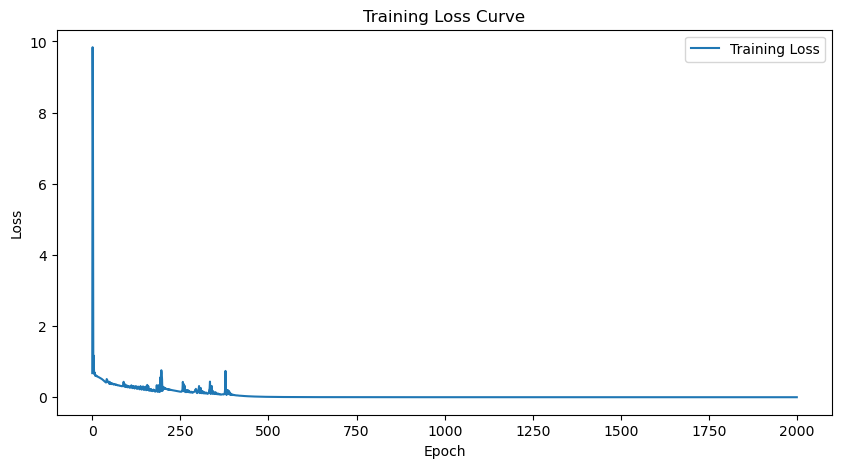

Best Model was saved at epoch 10 with F1-score 0.8050 and accuracy 67.37%


In [16]:
input_dim = X_train.shape[1]
hidden_dim = 256

custom_mlp, losses, best_accuracy, best_f1 = train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim)

In [17]:
def save_checkpoint(model, optimizer, epoch, loss, filepath):
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved to '{filepath}'.")

save_checkpoint(custom_mlp, torch.optim.Adam(custom_mlp.parameters()), len(losses), losses[-1], checkpoint_file)

Checkpoint saved to '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_last_token.pth'.


In [ ]:
print(f"Final Model Accuracy: {best_accuracy * 100:.2f}%")
y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()
print(classification_report(y_test, y_pred_final, target_names=["infringement", "non_infringement"]))

Final Model Accuracy: 67.37%
                  precision    recall  f1-score   support

    infringement       0.00      0.00      0.00        31
non_infringement       0.67      1.00      0.81        64

        accuracy                           0.67        95
       macro avg       0.34      0.50      0.40        95
    weighted avg       0.45      0.67      0.54        95



/tmp/ipykernel_3881958/3740627605.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()
/home/guangwei/miniconda3/envs/zdh/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/guangwei/miniconda3/envs/zdh/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

: 